# ▶️**This notebook was inspired by [this video by Veritasium](https://www.youtube.com/watch?v=KZeIEiBrT_w)**

# **📁 1. Imports and Setup**

In [1]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import string
import plotly.express as px
import random
from scipy.stats import gaussian_kde
import utils

# **🧭 2. Introduction**

In this notebook, we explore two fundamental concepts in probability and computational simulation: **Markov Chains** and the **Monte Carlo Theorem**. Both are powerful tools for modeling and understanding systems influenced by randomness.

We’ll start from simple examples and progressively move toward more complex and realistic applications.  

### **Main goals of this notebook:**

1. 🌀 **Understand Markov Chains**  
   Learn how systems that evolve step-by-step according to probabilities can be modeled — for example, predicting weather transitions between sunny, cloudy, and rainy days.

2. 🎲 **Apply the Monte Carlo Method**  
   Use random sampling to estimate quantities that are difficult to calculate analytically, such as the **area under a curve**.

3. ⚛️ **Simulate a Nuclear Chain Reaction**  
   Inspired by one of the early computational problems of the Manhattan Project, we’ll use probabilistic modeling to estimate whether nuclear fission can produce a **self-sustaining chain reaction**.

These examples will show how **randomness**, when used correctly, becomes a powerful computational ally to predict, estimate, and understand physical systems.

# **📚 3. Theoretical Background**

### **3.1. Markov Chains**

A **Markov Chain** is a mathematical system that undergoes transitions from one state to another according to certain probabilities.

It is characterized by the **Markov property**:  
> The future state depends only on the present state, not on the sequence of events that preceded it.

Formally, for a sequence of states $X_1, X_2, X_3, \ldots$:

$$
P(X_{n+1} = s_j \mid X_n = s_i, X_{n-1}, \ldots, X_1) = P(X_{n+1} = s_j \mid X_n = s_i)
$$

We represent the system with:
- A **set of states**, e.g., $S = \{ \text{Sunny}, \text{Cloudy}, \text{Rainy} \}$
- A **transition matrix** $P$, where $P_{ij}$ is the probability of going from state $i$ to state $j$:


$$
P = 
\begin{bmatrix}
P_{11} & P_{12} & P_{13} \\
P_{21} & P_{22} & P_{23} \\
P_{31} & P_{32} & P_{33}
\end{bmatrix}
$$

Each row sums to 1:

$$
\sum_j P_{ij} = 1
$$


**Example intuition:**
- If today is “Sunny,” tomorrow has a 70% chance of being Sunny again, a 20% chance of being Cloudy, and a 10% chance of being Rainy.
- Over time, this model can reach a **steady-state distribution** where the probabilities of each state stabilize.

---

### **3.2. Monte Carlo Theorem**

The **Monte Carlo Method** uses random sampling to approximate results that are deterministic in theory but hard to compute analytically.  

It’s based on the **Law of Large Numbers**, which states that as the number of random samples increases, the average of the results converges to the expected (true) value.

#### **Example: Estimating an Area Under a Curve**

Suppose we want to find the area under $f(x) = \sin(x)$ between 0 and $\pi$:

$$
A = \int_0^{\pi} \sin(x) \, dx
$$

Instead of solving analytically, we can:

1. Randomly generate $N$ points $(x_i, y_i)$ within the bounding box $[0, \pi] \times [0, 1]$.
2. Count how many points fall **below** the curve: $y_i < f(x_i)$.
3. Approximate the area as:

$$
A \approx \frac{N_{\text{below}}}{N_{\text{total}}} \times (\pi \times 1)
$$

As $N$ grows, this approximation becomes more accurate.


---

### **3.3. From Monte Carlo to Chain Reactions**

The **Monte Carlo approach** can simulate any process governed by random events — including nuclear fission.

In a nuclear chain reaction:
- Each fission event releases **neutrons** that may cause additional fissions.
- Some neutrons **escape** or are **absorbed** without causing further reactions.
- The process can be viewed as a **Markov chain**: each generation of neutrons depends probabilistically on the previous one.

The key parameter is the **effective multiplication factor** $K_{\text{eff}}$:

$$
K_{\text{eff}} = \frac{\text{Neutrons in generation } (n+1)}{\text{Neutrons in generation } n}
$$

- If $K_{\text{eff}} < 1$: the reaction dies out (*subcritical*).  
- If $K_{\text{eff}} = 1$: the reaction is self-sustaining (*critical*).  
- If $K_{\text{eff}} > 1$: the reaction grows exponentially (*supercritical*).


By simulating many random events using the Monte Carlo method, we can estimate whether the reaction is likely to sustain itself — just like early physicists did during the Manhattan Project.


# **✍️ 4. Markov Chains Origin** 

In [2]:
# Load a small subset of the dataset (1%)
dataset = load_dataset("opus_books", "en-es", split="train[:1%]")  # Small subset
# Extract English text (key 'translation' with subkey 'en')
text = " ".join([x['translation']['en'] for x in dataset])

# Classification: vowel or consonant
def is_vowel(c):
    return c.lower() in 'aeiou'

# Filter the text: only lowercase alphabetic characters
filtered_text = [c.lower() for c in text if c.lower() in string.ascii_lowercase]

# Calculate real distribution

# Convert to V (vowel) and C (consonant)
vc_sequence = ['V' if is_vowel(c) else 'C' for c in filtered_text]

# Count and normalize
total_vowels = vc_sequence.count('V')
total_consonants = vc_sequence.count('C')
p_vowel = total_vowels / len(vc_sequence)
p_consonant = total_consonants / len(vc_sequence)

print(f"""The text contains {len(filtered_text)} letters
Real distribution: Vowels = {p_vowel:.4f}, Consonants = {p_consonant:.4f}""")

The text contains 100860 letters
Real distribution: Vowels = 0.3820, Consonants = 0.6180


In [3]:
# Build transition matrix
# States: V, C /  Transitions: VV, VC, CV, CC
transitions = {
    'V': {'V': 0, 'C': 0},
    'C': {'V': 0, 'C': 0}
}

# To avoid having a matrix with all the information from the text, I'll just use the first subset
# This is to confirm that it will follow the law of large numbers (i.e., that the probabilities will follow
# the actual distribution)

N = int(len(filtered_text) * 0.01)  # Let's say I only have 1% of the information for the matrix
vc_sequence = vc_sequence[:N]

for i in range(len(vc_sequence) - 1):
    current = vc_sequence[i]
    next_char = vc_sequence[i + 1]
    transitions[current][next_char] += 1
    #print(i, transitions)

# Normalize
transition_matrix = {
    state: {k: v / sum(state_dict.values()) for k, v in state_dict.items()}
    for state, state_dict in transitions.items()
}

math_mtrz_trans = np.array([
    [transition_matrix['V']['V'], transition_matrix['V']['C']],  # V -> V, V -> C
    [transition_matrix['C']['V'], transition_matrix['C']['C']]   # C -> V, C -> C
])

print("\nTransition Matrix:")
for state, probs in transition_matrix.items():
    print(f"{state} -> {probs}")

# Simulation
## Bags to store the C/V ratio
prob_bag_C = []
prob_bag_V = []

for _ in range(0, 10000):

    # Initial probabilities randomly (stochastic)
    rnmd_p_vowel = np.random.rand()  # Probability of being a vowel
    rnmd_p_consonant = 1 - rnmd_p_vowel  # consonant

    # Initialize the state with the initial probabilities
    init_state = np.array([rnmd_p_vowel, rnmd_p_consonant])

    sim_length = 4  # Number of steps in the simulation
    for _ in range(sim_length):

        # Evolve the state using the transition matrix
        init_state = init_state @ math_mtrz_trans  # Multiply the current state by the transition matrix

        # Store the current probabilities of being in V and C
        prob_bag_V.append(init_state[0])  # Probability of being in V (vowel)
        prob_bag_C.append(init_state[1])  # Probability of being in C (consonant)


Transition Matrix:
V -> {'V': 0.15503875968992248, 'C': 0.8449612403100775}
C -> {'V': 0.5290322580645161, 'C': 0.47096774193548385}


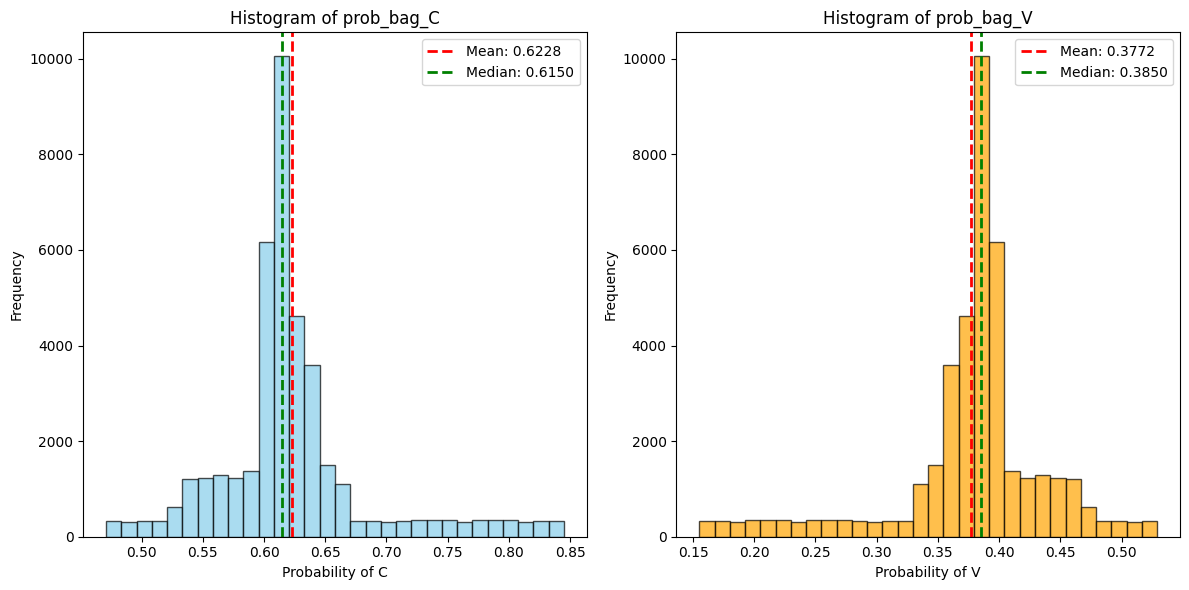

In [4]:
# Plot the histograms
utils.plot_simulation_histograms(prob_bag_C, prob_bag_V)

# 🃏**5. Montecarlo Theorem Origin**

In [5]:
# Monte Carlo simulations
N = 100_000  # The larger the number of simulations, the more noticeable the convergence in the histogram; 1 million is recommended
results = []
won = 0
all_simulations = []

for i in range(1, N + 1):
    victory = utils.play_solitaire()
    all_simulations.append(int(victory))
    if victory:
        won += 1
    results.append(won / i)

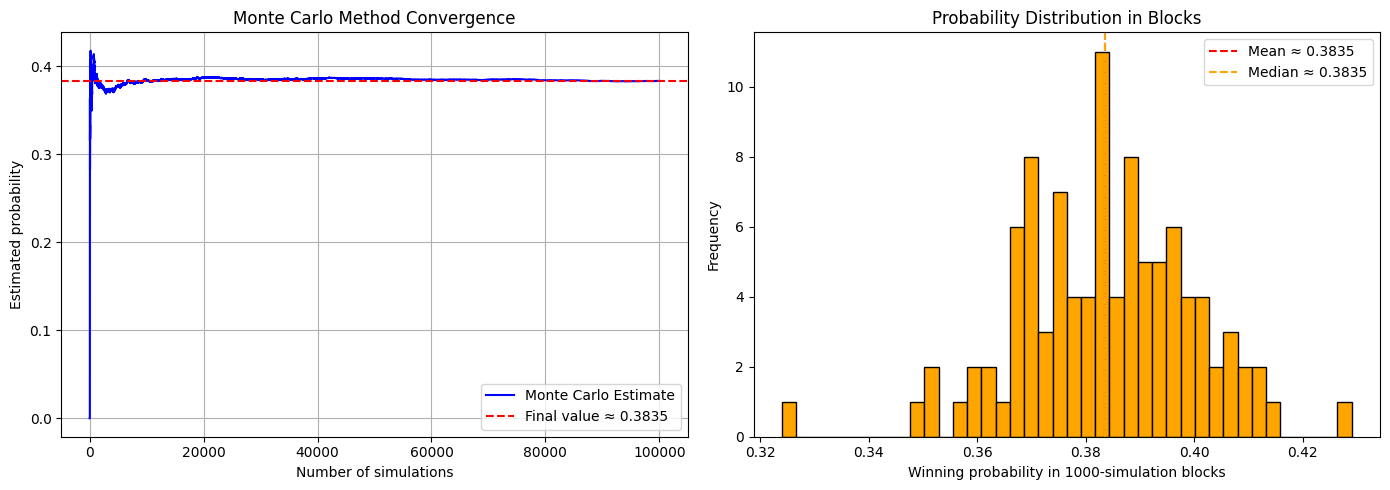

In [6]:
utils.plot_monte_carlo_results(results, all_simulations, N)

# 🧪**6. Example 3 – Chain Reaction Simulation (Manhattan Project Concept)**

In [7]:
# Monte Carlo simulation
N = 1*100_000
successes = 0
K_eff_estimates, success_rate = [] , []

for i in range(1,N+1):
    sustained, K= utils.simulate_chain_reaction_generational()
    if sustained:
        successes += 1
    K_eff_estimates.append(K)
    success_rate.append(successes/i)

final_prob = successes / N
print(f""" When creating {N} samples, we had {successes} success cases
Final estimated probability of self-sustaining chain reaction ≈ {final_prob:.4f}""")

 When creating 100000 samples, we had 75829 success cases
Final estimated probability of self-sustaining chain reaction ≈ 0.7583


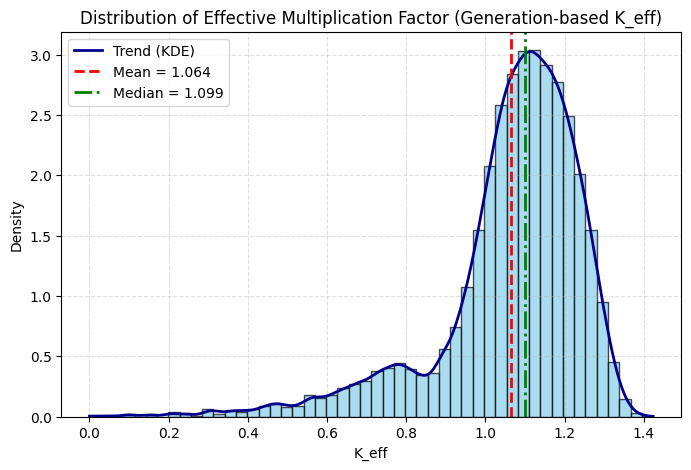

In [8]:
utils.plot_k_eff_distribution(K_eff_estimates)

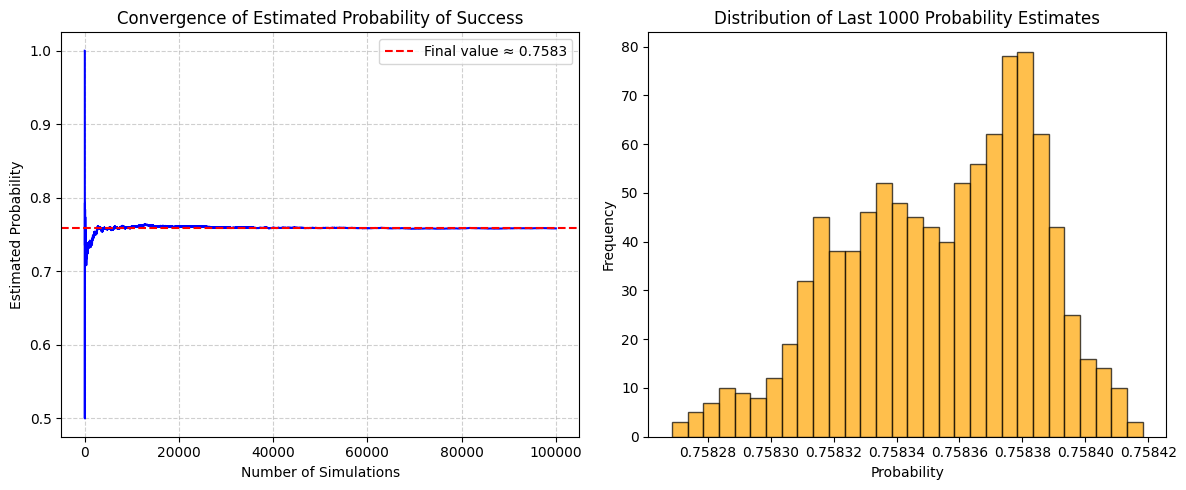

Final estimated probability of self-sustaining chain reaction ≈ 0.7583


In [9]:
utils.plot_success_rate_convergence(success_rate, N)

# **🎫 8. Reference/Support material**

### **Markov Chain Example – Weather Prediction with**

In [10]:
# Define the transition matrix P (probabilities of moving from one state to another)
P = np.array([
    [0.7, 0.2, 0.1],  # Sunny -> Sunny, Cloudy, Rainy
    [0.3, 0.5, 0.2],  # Cloudy -> Sunny, Cloudy, Rainy
    [0.2, 0.4, 0.4]   # Rainy -> Sunny, Cloudy, Rainy
])

# Define the initial probability vector v0
v0 = np.array([0.8, 0.15, 0.05])  # Probability that today is Sunny, Cloudy, or Rainy

# Calculate the probability of being in each state tomorrow (matrix multiplication)
v1 = np.dot(v0, P)  # v1 = v0 * P

# Print the results
states = ["Sunny", "Cloudy", "Rainy"]
for i in range(len(states)):
    print(f"Probability that tomorrow will be {states[i]}: {v1[i]:.2f}")


Probability that tomorrow will be Sunny: 0.61
Probability that tomorrow will be Cloudy: 0.26
Probability that tomorrow will be Rainy: 0.13


In [11]:
# After n days
n = 5
v_n = np.dot(v0, np.linalg.matrix_power(P, n))

# Print the results
states = ["Sunny", "Cloudy", "Rainy"]
for i in range(len(states)):
    print(f"Probability that in {n} days it will be {states[i]}: {v_n[i]:.2f}")

Probability that in 5 days it will be Sunny: 0.47
Probability that in 5 days it will be Cloudy: 0.34
Probability that in 5 days it will be Rainy: 0.19


### **Using Montecarlo Theorem to approximate area under a curve** 

Out of 10000 random points, 6660 are not under the curve.
3340 points are under the curve.
Percentage of points under the curve: 33.40%
Estimated area under the curve: 668.0000


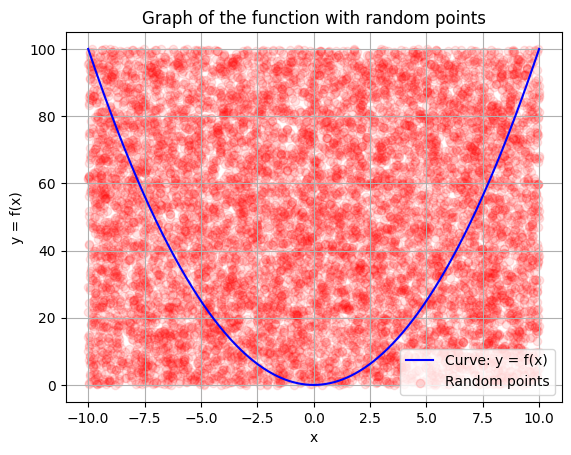

668.0

In [12]:
utils.montecarlo_area_below_function(a = 10, y_func= lambda x: x**2)

### **Difference between Markov Chains & Montecarlo** 

| Aspect              | Markov Chains                                                   | Montecarlo Method                                           |
| ------------------- | --------------------------------------------------------------- | ------------------------------------------------------------ |
| Purpose             | Model sequential processes with dependence on the current state | Estimate results/probabilities through random simulations    |
| Temporal Dependence | Yes, from current state to next state                           | Not necessarily; each simulation can be independent          |
| Approach            | Analytical, probabilistic                                       | Computational, empirical                                     |
| Output              | State distributions, transition probabilities                   | Estimation of values, probabilities, or integrals            |
| Example             | Weather, inventory stock, bank queues                           | Solitaire, numerical integration, financial option valuation |


💡 **Way to think about it:**

* **Markov:** “If I know where I am now, I can predict the future.”
* **Monte Carlo:** “I can’t calculate it directly, so I’ll try many times and see what happens.”


💡 **Relation with the Law of Large Numbers (LLN):**

*Both rely on the Law of Large Numbers, but ***Monte Carlo applies it to independent repetitions***, while ****Markov applies it to correlated observations**** throughout a process.*

🔑 **Practical Difference**

* **Monte Carlo:** You use the LLN to approximate probabilities through independent simulations.
* **Markov:** The LLN appears in the frequency of states over a dependent process, not in independent experiments.

### **Manhattan Project notes**

⚛️ **1. What actually happens in fission**

When a heavy nucleus (like Uranium-235) absorbs a neutron, it becomes unstable and splits into two smaller nuclei. 

This process — ***fission*** — releases:

*   **Energy** (as heat and radiation), and
*   **More neutrons** (usually 2 or 3 on average).

But the **exact number** of neutrons released per fission is **random** — it can be 0, 1, 2, 3, or even slightly more. 

The **average** is about **2.4** neutrons per fission for uranium-235.